# Logistic Regression with Diabetes Dataset
John Bonfardeci
2020-01-24

## Import External Libraries

In [13]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Additional libs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
from scipy import stats
from scipy.special import boxcox1p # handles zeroes
from sklearn.metrics import auc, confusion_matrix
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import RFE, SelectFromModel, SelectFpr
from sklearn import preprocessing # variance scaling

# John B's Stat Custom Utilities
from StatUtilities import Utilities as u

import math

## Contansts & Global Vars

In [2]:
FILE_PATH = 'diabetes.csv'
TARGET = 'Diabetic'
COLUMN_NAMES = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure', \
                 'TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']

OUTPUT_DIR = ''
df_raw = None # Pandas DataFrame for raw imported data.
df = None # Pandas DataFrame to store our model data.
df_coef = None # DataFrame to store predictor coefficients and p-values

## Global Functions

In [17]:
def to_matrix(df):
    return df[df.columns.tolist()].values.tolist()

def cols_to_list(df):
    tmp = df.copy()
    tmp = tmp.drop(TARGET, 1)
    return tmp.columns.values.tolist()

def get_hist(df):
    """
    Create histograms for each variable in a Pandas DataFrame.
    """
    tmp = pd.DataFrame()
    if type(df) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return

    for col in df.columns:
        ax = df[col].hist()
        ax.set_title(col)
        plt.show()
        
def get_boxplot(df):
    """
    Create boxplots for each variable in a Pandas DataFrame.
    """
    tmp = pd.DataFrame()
    if type(df) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return

    for col in df.columns:
        ax = sns.boxplot(x=df[col])
        ax.set_title(col)
        plt.show()

# SAMPLE

In [4]:
def split_data(df, columns, target):  
    # Separate features and labels
    X, y = df[columns].values, df[target].values
    # Split data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    return X_train, X_test, y_train, y_test
    

## Load the Dataset
Features error checking for file exists.

In [18]:
# Import data and display a summary table.
def import_data(file_path):
    """
    Import a CSV file to a Pandas dataframe.
    @param file_path <string>
    @return Pandas Dataframe
    """
    try:
        if not os.path.exists(file_path):
            print('Invalid file path!')
            return None

        df = pd.read_csv(file_path) # returns new Pandas DataFrame 
        return df
    except IOError:
        print('Error reading file ' + file_path)
        return None

if __name__ == '__main__':
    df_raw = import_data(FILE_PATH)
    # Drop the ID column
    df_raw = df_raw.drop('PatientID', 1).dropna()
    display(df_raw.describe())

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.25580,107.850200,71.207500,28.81760,139.243600,31.567022,0.400944,30.134100,0.334400
std,3.40572,31.920909,16.801478,14.50648,133.777919,9.804366,0.381463,12.106047,0.471804
min,0.00000,44.000000,24.000000,7.00000,14.000000,18.200807,0.078044,21.000000,0.000000
25%,0.00000,84.000000,58.000000,15.00000,39.000000,21.247427,0.137065,22.000000,0.000000
50%,2.00000,105.000000,72.000000,31.00000,85.000000,31.922421,0.199698,24.000000,0.000000
75%,6.00000,129.000000,85.000000,41.00000,197.000000,39.328921,0.621158,35.000000,1.000000
max,14.00000,192.000000,117.000000,92.00000,796.000000,56.034628,2.301594,77.000000,1.000000


# EXPLORE

## Univariate Analysis

In [ ]:
if __name__ == '__main__':
    get_hist(df_raw)

In [ ]:
if __name__ == '__main__':
    df = df_raw.copy().drop(TARGET, 1)
    get_boxplot(df)

## Multivariate Analysis

In [ ]:
def get_corrs(df):
    #Compute Percentage Change
    rets = df.pct_change()

    #Compute Correlation
    corr = rets.corr()

    #Plot Correlation Matrix using Matplotlib
    %pylab inline
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='Dark2', interpolation='none', aspect='auto') 
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr)), corr.columns);
    plt.suptitle('Diabetes Correlations Heat Map', fontsize=15, fontweight='bold')
    plt.show()
    
if __name__ == '__main__':
    get_corrs(df_raw)

## Outlier Handling

In [19]:
outliers = pd.DataFrame()
df = df_raw.copy()
outliers['PlasmaGlucose_outlier'] = list(map(lambda n: 1 if n < 16.5 else 0, df['PlasmaGlucose'].values))

outliers['DiastPressure_outlier'] = list(map(lambda n: 1 if n < 17.5 else 0, df['DiastolicBloodPressure'].values))

outliers['Triceps_outlier'] = list(map(lambda n: 1 if n > 80.0 else 0, df['TricepsThickness'].values))

outliers['Insulin_outlier'] = list(map(lambda n: 1 if n > 434.0 else 0, df['SerumInsulin'].values))

outliers['Pedigree_outlier'] = list(map(lambda n: 1 if n > 1.35 else 0, df['DiabetesPedigree'].values))

outliers['Age_outlier'] = list(map(lambda n: 1 if n > 54.5 else 0, df['Age'].values))

outliers.describe()

,PlasmaGlucose_outlier,DiastPressure_outlier,Triceps_outlier,Insulin_outlier,Pedigree_outlier,Age_outlier
count,10000.0,10000.0,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.0,0.0,0.00160,0.044800,0.031200,0.068500
std,0.0,0.0,0.03997,0.206875,0.173867,0.252615
min,0.0,0.0,0.00000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.00000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.00000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.00000,0.000000,0.000000,0.000000
max,0.0,0.0,1.00000,1.000000,1.000000,1.000000


In [20]:
df_raw = pd.concat([df_raw, outliers], 1)

## Get Estmimates Coefficients and P-values

In [21]:
def get_var_estimates(target_name, y, X, columns):
    """
    Show OLS parameter estimates for the model.
    Ref: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html
    @param target_name <string>
    @param y <list>
    @param X <Pandas Dataframe>
    @param columns <list>
    @returns Statsmodel summary
    """
    model = sm.OLS(y, X)
    results = model.fit()
    summary = results.summary(yname=target_name, xname=columns, title='PValues', alpha=0.05)
    
    # Build dataframe to store coeffients and p-values.
    predictors = []
    for row in summary.tables[1].data:
        try:
            pvalue = float(row[4])
            if pvalue < 0.05:
                col = row[0]
                coef = float(row[1])
                predictors.append([col, coef, pvalue])
        except:
            continue
        
    df_coef = pd.DataFrame(data=predictors, columns=['Predictor', 'Coef', 'Pvalue'])
    df_coef = df_coef.sort_values('Coef', ascending=False)  
    display(df_coef)
      
    return summary, df_coef
    
if __name__ == '__main__':
    col_names = cols_to_list(df_raw)
    print(col_names)
    X_train, X_test, y_train, y_test = split_data(df_raw, col_names, TARGET)
    summary, df_coef = get_var_estimates(target_name=TARGET, y=y_train, X=X_train, columns=col_names)
    display(summary)
    

['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age', 'PlasmaGlucose_outlier', 'DiastPressure_outlier', 'Triceps_outlier', 'Insulin_outlier', 'Pedigree_outlier', 'Age_outlier']


,Predictor,Coef,Pvalue
10,Triceps_outlier,3.179000e-01,0.003
12,Pedigree_outlier,1.676000e-01,0.000
6,DiabetesPedigree,7.670000e-02,0.000
0,Pregnancies,4.450000e-02,0.000
7,Age,8.100000e-03,0.000
5,BMI,1.900000e-03,0.000
3,TricepsThickness,1.100000e-03,0.001
4,SerumInsulin,6.000000e-04,0.000
8,PlasmaGlucose_outlier,1.558000e-16,0.022
9,DiastPressure_outlier,3.556000e-17,0.018


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        PValues                                        
=======================================================================================
Dep. Variable:               Diabetic   R-squared (uncentered):                   0.531
Model:                            OLS   Adj. R-squared (uncentered):              0.530
Method:                 Least Squares   F-statistic:                              658.5
Date:                Sun, 26 Jan 2020   Prob (F-statistic):                        0.00
Time:                        20:11:23   Log-Likelihood:                         -3440.7
No. Observations:                7000   AIC:                                      6905.
Df Residuals:                    6988   BIC:                                      6988.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Pregnancies                0.0445      0.001     31.003      0.000       0.042       0.047
PlasmaGlucose             -0.0003      0.000     -2.608      0.009      -0.001   -8.66e-05
DiastolicBloodPressure    -0.0030      0.000    -12.606      0.000      -0.003      -0.002
TricepsThickness           0.0011      0.000      3.395      0.001       0.000       0.002
SerumInsulin               0.0006   4.85e-05     12.836      0.000       0.001       0.001
BMI                        0.0019      0.000      4.276      0.000       0.001       0.003
DiabetesPedigree           0.0767      0.015      5.018      0.000       0.047       0.107
Age                        0.0081      0.001     15.767      0.000       0.007       0.009
PlasmaGlucose_outlier   1.558e-16    6.8e-17      2.291      0.022    2.25e-17    2.89e-16
DiastPressure_outlier   3.556e-17    1.5e-17      2.364      0.018    6.07e-18     6.5e-17
Triceps_outlier            0.3179      0.108      2.951      0.003       0.107       0.529
Insulin_outlier           -0.1107      0.031     -3.544      0.000      -0.172      -0.049
Pedigree_outlier           0.1676      0.034      4.885      0.000       0.100       0.235
Age_outlier                0.0232      0.025      0.931      0.352      -0.026       0.072
==============================================================================
Omnibus:                      604.783   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              386.622
Skew:                           0.453   Prob(JB):                     1.11e-84
Kurtosis:                       2.290   Cond. No.                     8.65e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.71e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
ax = sns.barplot(y="Predictor", x="Coef", data=df_coef)

# MODIFY

## LASSO feature selection

In [25]:
if __name__ == '__main__':
    col_names = cols_to_list(df_raw)
    
    X_train, X_test, y_train, y_test = split_data(df_raw, col_names, TARGET)
    
    significant_features = u.get_lasso_selection(X_train, y_train, col_names)
    
    print('Selected significant variables are:\r\n', ', '.join(significant_features))
    
    df = u.remove_insignificant_vars(significant_features, df_raw.copy())
    
    display(df.describe())
    
    X = to_matrix(df) 

Selected significant variables are:
 Pregnancies, PlasmaGlucose, DiastolicBloodPressure, TricepsThickness, SerumInsulin, BMI, DiabetesPedigree, Age

Dropped insignificant vars:  Diabetic, PlasmaGlucose_outlier, DiastPressure_outlier, Triceps_outlier, Insulin_outlier, Pedigree_outlier, Age_outlier


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.25580,107.850200,71.207500,28.81760,139.243600,31.567022,0.400944,30.134100
std,3.40572,31.920909,16.801478,14.50648,133.777919,9.804366,0.381463,12.106047
min,0.00000,44.000000,24.000000,7.00000,14.000000,18.200807,0.078044,21.000000
25%,0.00000,84.000000,58.000000,15.00000,39.000000,21.247427,0.137065,22.000000
50%,2.00000,105.000000,72.000000,31.00000,85.000000,31.922421,0.199698,24.000000
75%,6.00000,129.000000,85.000000,41.00000,197.000000,39.328921,0.621158,35.000000
max,14.00000,192.000000,117.000000,92.00000,796.000000,56.034628,2.301594,77.000000


## Box-Cox Transformation

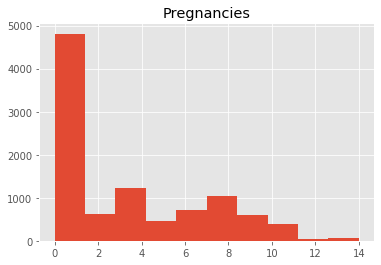

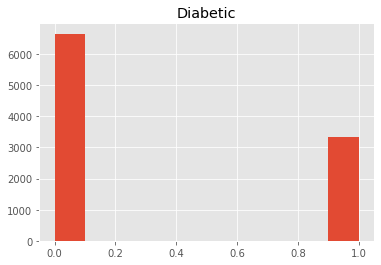

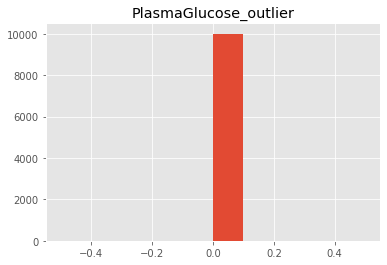

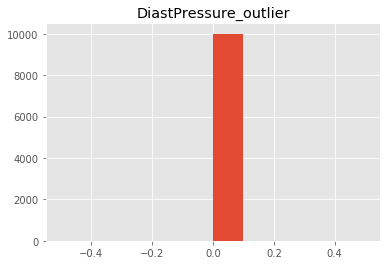

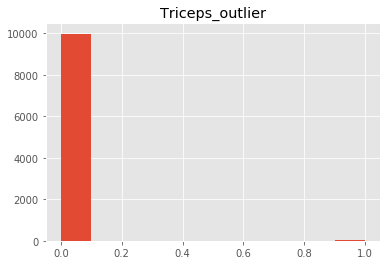

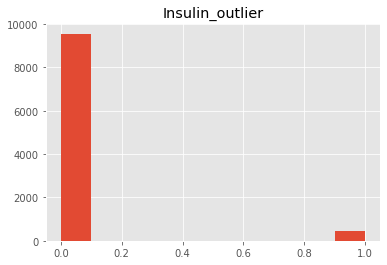

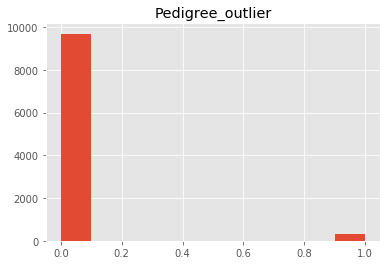

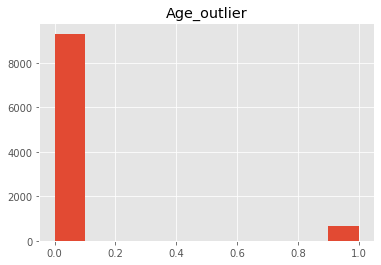

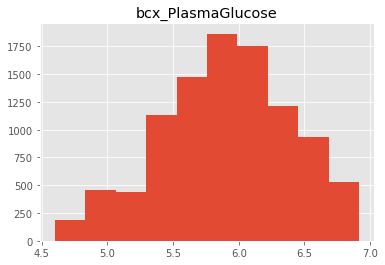

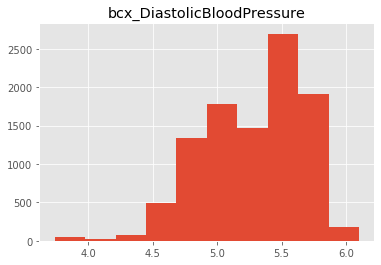

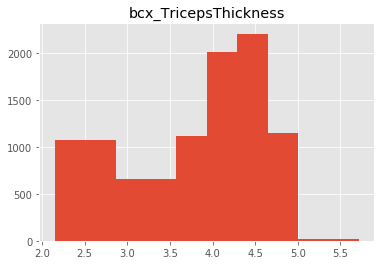

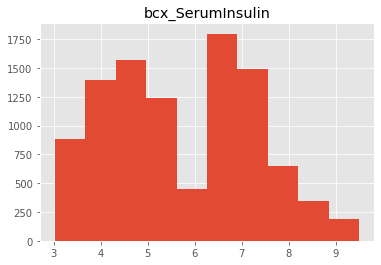

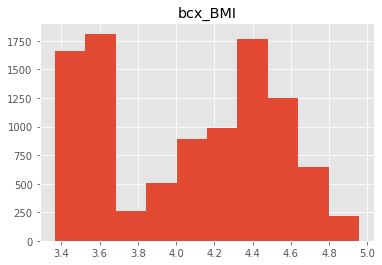

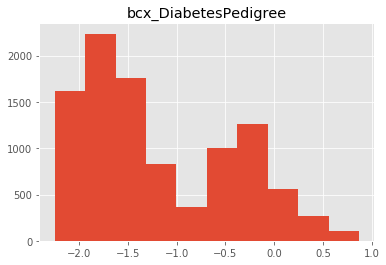

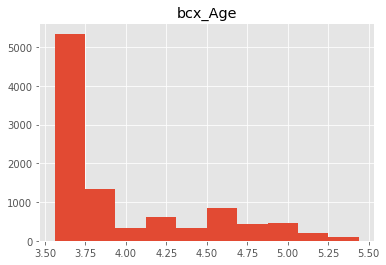

,Predictor,Coef,Pvalue
2,Triceps_outlier,3.382000e-01,0.001
11,bcx_Age,1.621000e-01,0.000
3,Pedigree_outlier,1.532000e-01,0.000
4,Age_outlier,1.021000e-01,0.000
10,bcx_DiabetesPedigree,6.850000e-02,0.000
9,bcx_BMI,6.180000e-02,0.000
8,bcx_SerumInsulin,4.990000e-02,0.000
0,Pregnancies,4.700000e-02,0.000
7,bcx_TricepsThickness,2.630000e-02,0.000
1,PlasmaGlucose_outlier,1.008000e-16,0.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        PValues                                        
=======================================================================================
Dep. Variable:               Diabetic   R-squared (uncentered):                   0.531
Model:                            OLS   Adj. R-squared (uncentered):              0.531
Method:                 Least Squares   F-statistic:                              660.5
Date:                Sun, 26 Jan 2020   Prob (F-statistic):                        0.00
Time:                        20:11:32   Log-Likelihood:                         -3435.1
No. Observations:                7000   AIC:                                      6894.
Df Residuals:                    6988   BIC:                                      6977.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Pregnancies                    0.0470      0.001     32.977      0.000       0.044       0.050
PlasmaGlucose_outlier       1.008e-16   2.79e-17      3.612      0.000    4.61e-17    1.55e-16
DiastPressure_outlier      -5.967e-17   4.86e-17     -1.228      0.219   -1.55e-16    3.56e-17
Triceps_outlier                0.3382      0.106      3.177      0.001       0.130       0.547
Insulin_outlier                0.0100      0.025      0.393      0.694      -0.040       0.060
Pedigree_outlier               0.1532      0.030      5.037      0.000       0.094       0.213
Age_outlier                    0.1021      0.023      4.459      0.000       0.057       0.147
bcx_PlasmaGlucose             -0.0485      0.008     -5.780      0.000      -0.065      -0.032
bcx_DiastolicBloodPressure    -0.1398      0.010    -13.865      0.000      -0.160      -0.120
bcx_TricepsThickness           0.0263      0.006      4.643      0.000       0.015       0.037
bcx_SerumInsulin               0.0499      0.003     14.735      0.000       0.043       0.056
bcx_BMI                        0.0618      0.010      6.231      0.000       0.042       0.081
bcx_DiabetesPedigree           0.0685      0.007     10.233      0.000       0.055       0.082
bcx_Age                        0.1621      0.012     13.864      0.000       0.139       0.185
==============================================================================
Omnibus:                      469.977   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.285
Skew:                           0.399   Prob(JB):                     2.54e-68
Kurtosis:                       2.344   Cond. No.                     5.12e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.17e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

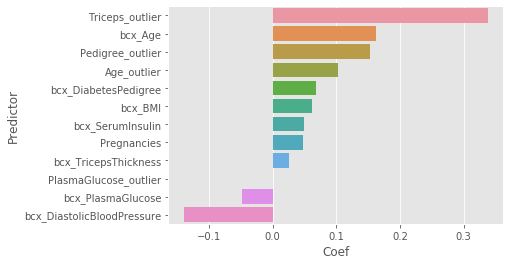

In [22]:
# Transform all predictors, except for dummy outler vars with Box-Cox formula.
if __name__ == '__main__':
    tx = df_raw.copy()
    lmbda = 0.1
    col_names = cols_to_list(tx)

    for cn in col_names:
        if not cn.endswith("_outlier"):
            mn = min(tx[cn].values.tolist())
            if mn > 0:
                tx["bcx_"+cn] = boxcox(tx[cn], lmbda)
                tx = tx.drop(cn, 1)

    get_hist(tx)
    columns = cols_to_list(tx)
    X_train, X_test, y_train, y_test = split_data(tx, columns, TARGET)
    summary, df_coef = get_var_estimates(target_name=TARGET, y=y_train, X=X_train, columns=columns)
    display(summary)
    ax = sns.barplot(y="Predictor", x="Coef", data=df_coef)

# MODEL with ASSESSMENT

In [23]:
if __name__ == '__main__':
    # Set regularization hyperparameter
    reg = 0.05

    columns = cols_to_list(df_raw)
    X_train, X_test, y_train, y_test = split_data(df_raw, columns, TARGET)

    model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

    # calculate accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)

    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))

Accuracy: 0.7753333333333333
AUC: 0.8499193989750734


## Use Cross Validation and Best Cutoff to Improve Fit
Produces ROC and confusion matrix to assess accuracy of model on the validation set.

Fold 1, TPR: 0.76946, TNR: 0.78378, Cutoff: 0.33000, Accuracy: 0.77662
Fold 2, TPR: 0.82212, TNR: 0.75432, Cutoff: 0.30000, Accuracy: 0.78822
Fold 3, TPR: 0.81465, TNR: 0.72427, Cutoff: 0.28000, Accuracy: 0.76946
Fold 4, TPR: 0.80269, TNR: 0.75958, Cutoff: 0.31000, Accuracy: 0.78113
Fold 5, TPR: 0.76682, TNR: 0.78512, Cutoff: 0.34000, Accuracy: 0.77597
Means: TPR: 0.79516, TNR: 0.76142, Cutoff: 0.31200, Accuracy: 0.77829
ROC image was saved to: logit-roc.png


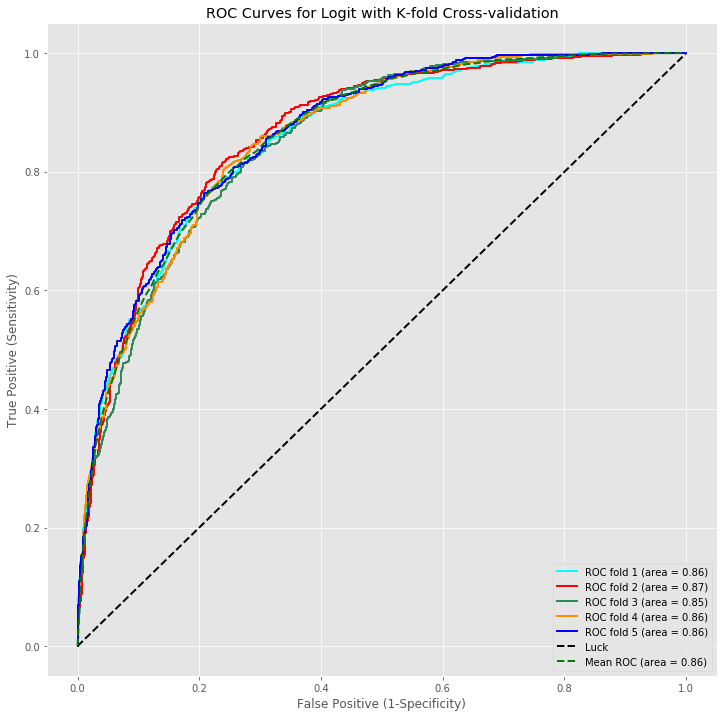

Confusion matrix image was saved to: logit-best-tp-cm.png


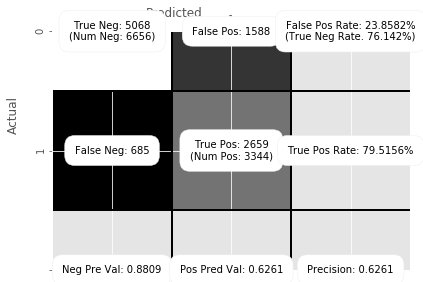

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,PlasmaGlucose_outlier,DiastPressure_outlier,Triceps_outlier,Insulin_outlier,Pedigree_outlier,Age_outlier,Diabetic,Prob_0,Prob_1,Predicted
9995,0.776098,-0.393816,0.791697,0.532384,0.934652,-1.293497,0.706152,0.066957,0.0,0.0,-0.044766,-0.218332,-0.180346,-0.270114,0,0.424079,0.575921,1
9996,-0.973184,-1.651963,-1.221142,-1.524344,-0.673367,-0.951465,-0.832474,0.317574,0.0,0.0,-0.044766,-0.218332,-0.180346,-0.270114,0,0.979196,0.020804,0
9997,0.484551,-0.268001,-0.747533,1.217960,-0.547393,-0.046703,5.108539,1.069427,0.0,0.0,-0.044766,-0.218332,5.544910,-0.270114,1,0.088808,0.911192,1
9998,-0.973184,1.178868,-0.273924,0.052481,-0.888264,-1.261575,1.053044,-0.350739,0.0,0.0,-0.044766,-0.218332,-0.180346,-0.270114,0,0.935529,0.064471,0
9999,1.942286,-0.236547,-1.043539,0.326711,-0.843803,0.772570,-0.594095,-0.601357,0.0,0.0,-0.044766,-0.218332,-0.180346,-0.270114,0,0.551940,0.448060,0


In [24]:
# Run logistic Regression with cross-validation and plot ROC curves
# Logit can use categorical variaables. Append to cols and get new data set
def fit_logit(X, y, col_names, num_cv=5, to_csv=False):
    """
    Fit a model with Logistic Regression.
    """
    #rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=num_cv) # split into N folds /shuffle=True, random_state=rand
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = [] # store TPR and FPR for each iteration and plot to ROC curve
    cm_folds = []
    logit_actual = []
    logit_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    predicted_data = []
    tn=[]; fp=[]; fn=[]; tp=[];
    
    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = preprocessing.scale(X[test])
        train_X = preprocessing.scale(X[train])
        train_y = y[train]

        # train Logit on training dataset
        logit = LogisticRegression(C=1/reg, solver="liblinear") #lbfgs
        logit.fit(train_X, train_y)

        # test Logit on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = logit.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = logit.predict(test_X)
        train_predicted = logit.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
        
        # add mean Sensitivity
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        logit_actual.extend(test_actual)
        logit_prob.extend(prob)
        best_tpr, best_fpr, best_cutoff, _tn, _fp, _fn, _tp = u.get_best_cutoff(actual=test_actual, prob=prob)
        roc_kfolds.append([tpr, fpr])
        best_mean_cutoff += best_cutoff
        tn.append(_tn)
        fp.append(_fp)
        fn.append(_fn)
        tp.append(_tp)
        accuracy = (best_tpr + (1-best_fpr)) / 2
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f, Accuracy: %0.5f' \
              % (i+1, best_tpr, 1-best_fpr, best_cutoff, accuracy))
    
        # Collect test set into combined table
        predicted_data.extend(u.combine(prob, test_X, test_actual, predicted))
        
        i += 1
    #/for (train, test)...

    best_mean_cutoff /= float(num_cv)
    tneg = sum(tn)
    fpos = sum(fp)
    fneg = sum(fn)
    tpos = sum(tp)
    best_mean_tpr = tpos / (tpos+fneg)
    best_mean_tnr = tneg / (tneg+fpos)
    accuracy = (best_mean_tpr + best_mean_tnr) / 2
    print('Means: TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f, Accuracy: %0.5f' \
          %(best_mean_tpr, best_mean_tnr, best_mean_cutoff, accuracy))

    # Display ROC Curve, output to CSV
    u.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, OUTPUT_DIR+'logit-roc')

    if to_csv:
        u.output_cms(OUTPUT_DIR+'logit-cms', cm_folds, OUTPUT_DIR+'Logit_Test_Folds') # output to excel

    # Display Confustion Matrix, output to PNG
    cm = np.asarray( [[tneg,fpos],[fneg,tpos]] )
    u.show_confusion_matrix(cm, ['0','1'], (6,6), 12, OUTPUT_DIR+'logit-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(col_names), np.asarray([TARGET, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    
    if to_csv:
        df.to_csv(OUTPUT_DIR + 'logit-validation.csv')
        
    display(df.tail())
    
if __name__ == '__main__':

    sig_vars = cols_to_list(df_raw)
    
    X, y = df_raw[sig_vars].values, df_raw[TARGET].values
    
    fit_logit(X=X, y=y, col_names=sig_vars, num_cv=5, to_csv=False)

In [ ]:
df = tx.drop(TARGET, 1)
X, y = df[df.columns.tolist()].values, tx[TARGET].values
# Means: TPR: 0.80383, TNR: 0.76367, Cutoff: 0.30800, Accuracy: 0.78375

df = len(X)-1
tp = 2688
fp = 1573
tn = 5083
fn = 656
total = tp+fp+tn+fn

actual_p = tp + fn
actual_n = tn + fp

print(actual_p, actual_n)

#chisq = (observed-expected)**2 / expected
pvalue = 0
